# COURSERA Capstone Project: Diversity of Restaurants in Singapore

### author: JL

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## 1. Introduction <a name="introduction"></a>

Singapore has the second greatest population density in the world, and has very vibrant and diverse communities. As a home to a wide range of cultures, ethnicities and religions, Singapore has a rich choice of different cuisines and restaurants. People from same background and culture tend to gather spatially and form local communities, and it is assumed that such spatial pattern of communities can be reflected by the popularity and distribution of different types of restaurants. For example, places that have many Chinese restaurants may be the places that Chinese communities stay or visit most. In addition, a map that presents the clusters of different types of cuisines in Singapore can be treated as a kind of food guide map for tourists and local citizens, which can be interesting despite commercial valuable.

This notebook will demonstrate how to achieve this goal with data analysis in Python. We first import all the required libraries.

In [21]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import plotly for map visualization
import plotly.express as px
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## 2. Data <a name="data"></a>

To achieve the product as described above, two major datasets are required, the spatial data of Singapore and food related Point of Interests (POI).

###  2.1 Spatial data of Singapore

To facilitate urban planning, the Urban Redevelopment Authority (URA) divides Singapore into regions, planning areas and subzones. The Planning Regions are divided into smaller Planning Areas. Each Planning Area is further divided into smaller subzones which are usually centred around a focal point such as neighbourhood centre or activity node. There are over three hundred subzones of a total of 55 planning areas, organised into 5 regions. To achieve a more detailed investigation, this project will be conducted in the subzone level.
The Singapore subzone shapefile data can be downloaded from the following link on data.gov.sg (https://data.gov.sg/dataset/master-plan-2019-subzone-boundary-no-sea). There are a total of 325 Singapore subzones in the data downloaded. 
The subzones are presented as polygons in the original shapefile. With the help of QGIS (a spatial analysis tool), we can extract the centroid of each subzone polygon. The subzone information including latitude, longitude and name, can be exported as a csv file for the use of POI collection later. 


In [22]:
# load SG subzone polygons json file
with open('SG_subzone_polygon.geojson') as json_data:
    SG_subzone_polygon = json.load(json_data)
    
# load Singapore subzone centroid data
SG_subzones = pd.read_csv('SG_subzone.csv')
SG_subzones.head()

,Lon,Lat,SUBZONE_NAME,SUBZONE_CODE,PLN_AREA_NAME,PLN_AREA_CODE,REGION_NAME,REGION_CODE
0,103.872352,1.288517,MARINA EAST,MESZ01,MARINA EAST,ME,CENTRAL REGION,CR
1,103.837500,1.294016,INSTITUTION HILL,RVSZ05,RIVER VALLEY,RV,CENTRAL REGION,CR
2,103.837064,1.291286,ROBERTSON QUAY,SRSZ01,SINGAPORE RIVER,SR,CENTRAL REGION,CR
3,103.698639,1.262532,JURONG ISLAND AND BUKOM,WISZ01,WESTERN ISLANDS,WI,WEST REGION,WR
4,103.846053,1.294046,FORT CANNING,MUSZ02,MUSEUM,MU,CENTRAL REGION,CR



### 2.2	Food related POI (restaurants) data

The restaurant data can be collected from Foursquare. We can search for all the POIs under the “Food” category (Foursquare categoryID is '4d4b7105d754a06374d81259') around each subzone centroid. The searching buffer is defined as 1 km to ensure a good coverage, the limit of venues returned per request was set as 100. A total of 16294 venues were collected. The POIs will be joint with subzones and more exploratory analysis will be conducted in the following sessions.


# define Foursquare Credentials 
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

In [23]:
# function that collect POI from Foursquare

def getNearbyVenues(names, latitudes, longitudes, radius, category_sel):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category_sel,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subzone', 
                  'Subzone Latitude', 
                  'Subzone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)   


# collect POI under 'Food' category around each subzone
SG_venues = getNearbyVenues(names = SG_subzones['SUBZONE_NAME'],
                            latitudes = SG_subzones['Lat'],
                            longitudes = SG_subzones['Lon'],
                            radius=2000,
                            category_sel= '4d4b7105d754a06374d81259' #Food
                           )

SG_venues = SG_venues.drop_duplicates()
SG_venues.to_csv('SG_venues.csv')

## 3 Methodology <a name="methodology"></a>

### 3.1 Exploratory Data Analysis

* Venue counts by subzone

We can first check how many food related POIs we have collected for each subzone

In [24]:
# inspect data by subzone
SG_venues = pd.read_csv('SG_venues.csv')

count_bySubzone = pd.DataFrame({'Venue Counts':SG_venues.groupby('Subzone')['Venue'].count()}).reset_index()

# initial settings for map visualization
SG_latitude = SG_subzones['Lat'].mean()
SG_longitude = SG_subzones['Lon'].mean()

zoom_level = 10
city_centre = {"lat": SG_latitude, "lon":SG_longitude }

We can use plotly package to create a map of venue counts. 
It can be observed that restaurants are mostly located in the city centre.
Some subzones are missing because there is no POI within the searching radius, and there subzones are the natural areas.

In [ ]:
# choropleth map
map_venueCounts = px.choropleth_mapbox(count_bySubzone, geojson=SG_subzone_polygon, 
                locations='Subzone', featureidkey="properties.SUBZONE_N",
                color='Venue Counts',
                color_continuous_scale="OrRd",
                hover_data=['Subzone', 'Venue Counts'],
                mapbox_style="carto-positron", 
                zoom=zoom_level,
                center=city_centre,
                opacity=0.8,
                title = "Venue counts by subzone"
                )
map_venueCounts.update_layout(height=500, margin={"r":0,"l":0,"b":0})
map_venueCounts.show()


* Venue counts by type

We can also check what restaurant types are most common in Singapore. 
As the plot shows, Chinese Restaurant is the most common type in Singapore. 


<AxesSubplot:ylabel='Venue Category'>

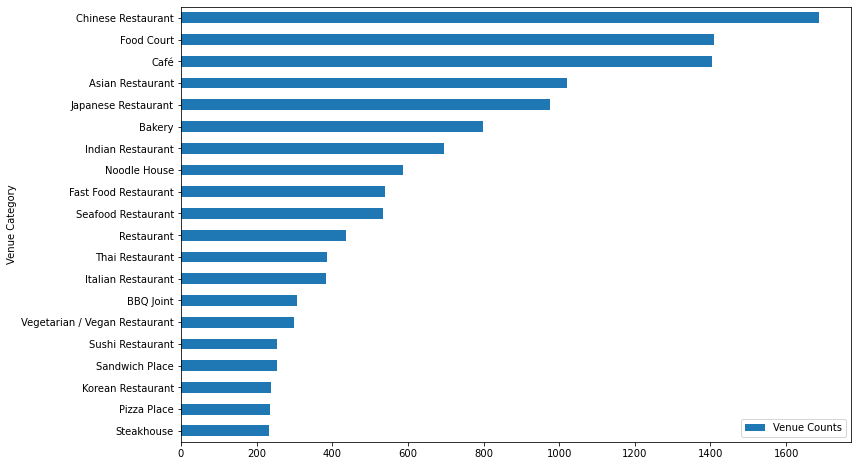

In [26]:
# group venue by category
count_byType = pd.DataFrame({'Venue Counts':SG_venues.groupby('Venue Category')['Venue'].count()}).reset_index()
df_plot = count_byType.sort_values(by='Venue Counts',ascending=False).head(20)

# create bar plot of the top 20 categories
df_plot.sort_values(by='Venue Counts').plot.barh(x='Venue Category', y='Venue Counts',figsize=(12,8))

### 3.2 Data processing 

* Calculate distribution of different restaurant types of each subzone.

In [27]:
# one hot encoding
SG_onehot = pd.get_dummies(SG_venues[['Venue Category']], prefix="", prefix_sep="")

# move Subzone column to the first column
Venue_categories = sorted(SG_venues['Venue Category'].unique().tolist())

# add Subzone column back to dataframe
SG_onehot['Subzone'] = SG_venues['Subzone'] 
SG_onehot = SG_onehot[['Subzone'] + Venue_categories]

print("SG_onehot shape: ", SG_onehot.shape)

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
SG_grouped = SG_onehot.groupby('Subzone').mean().reset_index()

print("SG_grouped shape: ", SG_grouped.shape)
SG_grouped.head()

SG_onehot shape:  (16294, 115)
SG_grouped shape:  (321, 115)


,Subzone,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Beijing Restaurant,Belgian Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Imperial Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Macanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Peking Duck Restaurant,Persian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yunnan Restaurant,Zhejiang Restaurant
0,ADMIRALTY,0.0,0.000000,0.0,0.047619,0.0,0.023810,0.0,0.071429,0.0,0.0,0.023810,0.000000,0.023810,0.0,0.0,0.0,0.000000,0.023810,0.00,0.0,0.0,0.0,0.0,0.119048,0.0,0.0,0.0,0.0,0.0,0.00,0.02381,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.00,0.0,0.023810,0.119048,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.02381,0.02381,0.000000,0.02381,0.0,0.000000,0.000000,0.047619,0.0,0.047619,0.0,0.023810,0.0,0.0,0.023810,0.0,0.000000,0.0,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.047619,0.0,0.0,0.0,0.000000,0.0,0.047619,0.0,0.0,0.0,0.00,0.023810,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.02381,0.0,0.0
1,AIRPORT ROAD,0.0,0.000000,0.0,0.047619,0.0,0.000000,0.0,0.095238,0.0,0.0,0.000000,0.142857,0.000000,0.0,0.0,0.0,0.142857,0.000000,0.00,0.0,0.0,0.0,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.00,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.00,0.0,0.000000,0.190476,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.047619,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047619,0.0,0.000000,0.000000,0.000000,0.047619,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00000,0.0,0.0
2,ALEXANDRA HILL,0.0,0.010309,0.0,0.061856,0.0,0.041237,0.0,0.072165,0.0,0.0,0.000000,0.020619,0.010309,0.0,0.0,0.0,0.010309,0.072165,0.00,0.0,0.0,0.0,0.0,0.216495,0.0,0.0,0.0,0.0,0.0,0.00,0.00000,0.0,0.0,0.010309,0.0,0.0,0.0,0.0,0.030928,0.00,0.0,0.010309,0.092784,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.010309,0.0,0.00000,0.00000,0.010309,0.00000,0.0,0.041237,0.000000,0.010309,0.0,0.020619,0.0,0.010309,0.0,0.0,0.020619,0.0,0.000000,0.0,0.0,0.0,0.072165,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.010309,0.0,0.030928,0.010309,0.010309,0.010309,0.0,0.0,0.0,0.010309,0.0,0.010309,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.020619,0.0,0.0,0.0,0.010309,0.

* check top 10 restaurant types of each subzone

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subzone']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Subzones_venues_sorted = pd.DataFrame(columns=columns)
Subzones_venues_sorted['Subzone'] = SG_grouped['Subzone']

for ind in np.arange(SG_grouped.shape[0]):
    Subzones_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SG_grouped.iloc[ind, :], num_top_venues)

Subzones_venues_sorted.head()


,Subzone,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADMIRALTY,Chinese Restaurant,Food Court,Fast Food Restaurant,Bakery,Soup Place,Italian Restaurant,Pizza Place,Asian Restaurant,Seafood Restaurant,Japanese Restaurant
1,AIRPORT ROAD,Food Court,Breakfast Spot,Cafeteria,Bakery,Noodle House,Chinese Restaurant,Restaurant,Asian Restaurant,Indian Restaurant,Fast Food Restaurant
2,ALEXANDRA HILL,Chinese Restaurant,Food Court,Noodle House,Café,Bakery,Asian Restaurant,BBQ Joint,Indian Restaurant,Sandwich Place,Fast Food Restaurant
3,ALEXANDRA NORTH,Chinese Restaurant,Café,Noodle House,Bakery,Food Court,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Hainan Restaurant,Bistro
4,ALJUNIED,Chinese Restaurant,Noodle House,Food Court,Dim Sum Restaurant,Seafood Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,Café,Thai Restaurant


### 3.3 Clustering

We are going to use K-means clustering method to identify subzones of similar restaurant distributions. 

As the basic parameter of K-means, we first need to identify the optimal number of clusters in our case. The elbow test is conducted here, the optimal K value is identified as 5.

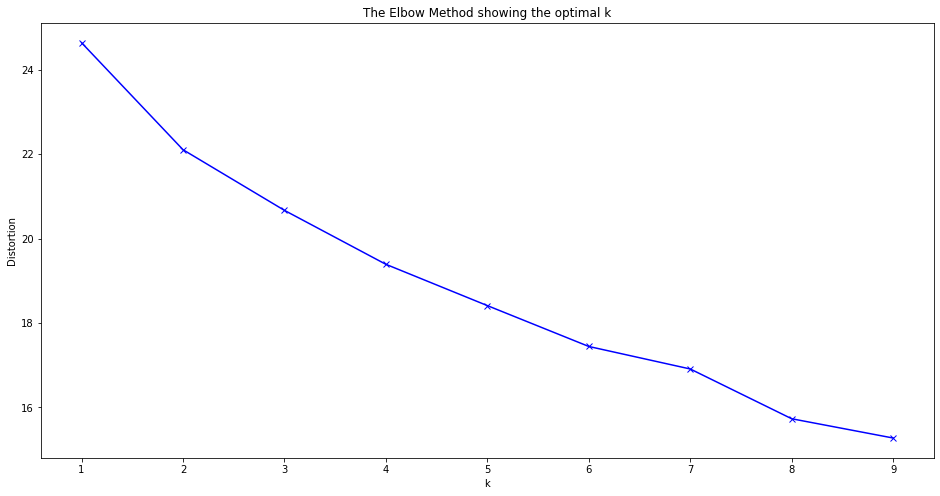

In [29]:
# elbow method of determine K for K means
SG_grouped_clustering = SG_grouped.drop('Subzone', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(SG_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can then apply K-means method to cluster the subzones into 5 groups. 

In [30]:
# Cluster Subzone

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SG_grouped_clustering)
# kmeans.labels_[0:10] 
# add clustering labels
Subzones_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Now each subzone has a cluster label, we can combine the dataframes for later analysis.

In [31]:
# merge dataframes
SG_merged = SG_subzones
SG_merged['Subzone'] = SG_merged['SUBZONE_NAME']

SG_merged = SG_merged.join(count_bySubzone.set_index('Subzone'), on='Subzone')
SG_merged = SG_merged.dropna()

SG_merged = SG_merged.join(Subzones_venues_sorted.set_index('Subzone'), on='Subzone')

# make cluster label column as str instead of int
SG_merged = SG_merged.astype({'Cluster Labels': 'str'})

SG_merged.head() 

,Lon,Lat,SUBZONE_NAME,SUBZONE_CODE,PLN_AREA_NAME,PLN_AREA_CODE,REGION_NAME,REGION_CODE,Subzone,Venue Counts,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,103.872352,1.288517,MARINA EAST,MESZ01,MARINA EAST,ME,CENTRAL REGION,CR,MARINA EAST,25.0,3,Café,Seafood Restaurant,BBQ Joint,Satay Restaurant,Food Court,American Restaurant,Imperial Restaurant,Sandwich Place,Fast Food Restaurant,French Restaurant
1,103.837500,1.294016,INSTITUTION HILL,RVSZ05,RIVER VALLEY,RV,CENTRAL REGION,CR,INSTITUTION HILL,100.0,4,Japanese Restaurant,Café,Chinese Restaurant,Steakhouse,Restaurant,Ramen Restaurant,Pizza Place,BBQ Joint,Bakery,Italian Restaurant
2,103.837064,1.291286,ROBERTSON QUAY,SRSZ01,SINGAPORE RIVER,SR,CENTRAL REGION,CR,ROBERTSON QUAY,100.0,4,Japanese Restaurant,Café,Chinese Restaurant,Bakery,Food Court,Seafood Restaurant,Restaurant,Asian Restaurant,Mexican Restaurant,Italian Restaurant
3,103.698639,1.262532,JURONG ISLAND AND BUKOM,WISZ01,WESTERN ISLANDS,WI,WEST REGION,WR,JURONG ISLAND AND BUKOM,6.0,3,Café,Food Court,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Beijing Restaurant,Food,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Dutch Restaurant
4,103.846053,1.294046,FORT CANNING,MUSZ02,MUSEUM,MU,CENTRAL REGION,CR,FORT CANNING,100.0,4,Japanese Restaurant,Café,Italian Restaurant,Steakhouse,Restaurant,Bakery,BBQ Joint,French Restaurant,Bistro,Vegetarian / Vegan Restaurant


## Results and Discussion <a name="results"></a>

We can create a map to show the clusters of the subzones based on their restaurant distribution.

You can click on each subzone to see the subzone name, total venue counts and top 3 types.

As shown in the map, the city centre are mostly cluster_2 and cluster_4, while the outer ring areas are mostly cluster_0, and areas with smaller population density are cluster_3.

In [ ]:
# Subzone clusters based on restaurant distribution

map_cluster = px.choropleth_mapbox(SG_merged, geojson=SG_subzone_polygon, 
                locations='Subzone', featureidkey="properties.SUBZONE_N",
                color='Cluster Labels',
                hover_data=['Subzone', 'Venue Counts','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'],
                mapbox_style="carto-positron", 
                zoom=zoom_level,
                center=city_centre,
                opacity=0.8,
                title = "Subzone clusters based on restaurant distributions"
                )

map_cluster.update_layout(height=500, margin={"r":0,"l":0,"b":0})
map_cluster.show()

We can also identify the most common restaurant type of each subzone. 

It can be observed that in the south centre (the CBD area), Japanese restaurants are most common. In the northern part, food court is the most common type, which is a very typical Singaporean place where diverse food choices are provided.


In [ ]:
# Most common restaurant type of each subzone
map_mostCommon = px.choropleth_mapbox(SG_merged, geojson=SG_subzone_polygon, 
                locations='Subzone', featureidkey="properties.SUBZONE_N",
                color='1st Most Common Venue',
                hover_data=['Subzone', '1st Most Common Venue'],
                mapbox_style="carto-positron", 
                zoom=zoom_level,
                center=city_centre,
                opacity=0.8,
                title = "Most common restaurant type of each subzone"
                )
map_mostCommon.update_layout(height=500, margin={"r":0,"l":0,"b":0})
map_mostCommon.show()

As the subzones have been grouped into 5 clusters, we can look into each of them. The distribution of different restaurant types of each cluster is displayed in the pie charts.

In [34]:
# Inspect restaurant distribution of each cluster
cluster_profile = SG_grouped.copy()
cluster_profile = cluster_profile.merge(SG_merged[['Subzone','Cluster Labels']], on='Subzone')
cluster_profile = cluster_profile.drop(columns = ['Subzone'])
cluster_profile = cluster_profile.groupby('Cluster Labels').mean().reset_index()

In [ ]:
# plot restaurant distribution of cluster_0
cluster_0 = cluster_profile.loc[cluster_profile['Cluster Labels'] == '0'].drop(columns=['Cluster Labels']).transpose().reset_index()
cluster_0.columns = ['Type','Percentage']
cluster_0.loc[cluster_0['Percentage'] < 0.03, 'Type'] = 'Others' # Represent only large types
fig_0 = px.pie(cluster_0, values='Percentage', names='Type', title='Restaurant distribution within cluster_0')
fig_0.show()

In [ ]:
# plot restaurant distribution of cluster 1
cluster_1 = cluster_profile.loc[cluster_profile['Cluster Labels'] == '1'].drop(columns=['Cluster Labels']).transpose().reset_index()
cluster_1.columns = ['Type','Percentage']
cluster_1.loc[cluster_1['Percentage'] < 0.03, 'Type'] = 'Others' # Represent only large types
fig_1 = px.pie(cluster_1, values='Percentage', names='Type', title='Restaurant distribution within cluster_1')
fig_1.show()

In [ ]:
# plot restaurant distribution of cluster_2
cluster_2 = cluster_profile.loc[cluster_profile['Cluster Labels'] == '2'].drop(columns=['Cluster Labels']).transpose().reset_index()
cluster_2.columns = ['Type','Percentage']
cluster_2.loc[cluster_2['Percentage'] < 0.03, 'Type'] = 'Others' # Represent only large types
fig_2 = px.pie(cluster_2, values='Percentage', names='Type', title='Restaurant distribution within cluster_2')
fig_2.show()

In [ ]:
# plot restaurant distribution of cluster_3
cluster_3 = cluster_profile.loc[cluster_profile['Cluster Labels'] == '3'].drop(columns=['Cluster Labels']).transpose().reset_index()
cluster_3.columns = ['Type','Percentage']
cluster_3.loc[cluster_3['Percentage'] < 0.03, 'Type'] = 'Others' # Represent only large types
fig_3 = px.pie(cluster_3, values='Percentage', names='Type', title='Restaurant distribution within cluster_3')
fig_3.show()

In [ ]:
# plot restaurant distribution of cluster_4
cluster_4 = cluster_profile.loc[cluster_profile['Cluster Labels'] == '4'].drop(columns=['Cluster Labels']).transpose().reset_index()
cluster_4.columns = ['Type','Percentage']
cluster_4.loc[cluster_4['Percentage'] < 0.03, 'Type'] = 'Others' # Represent only large types
fig_4 = px.pie(cluster_4, values='Percentage', names='Type', title='Restaurant distribution within cluster_4')
fig_4.show()

## Conclusion <a name="conclusion"></a>

This project is trying to explore the diversity of restaurants in Singapore and provide an overview of distributions of different restaurant types in different subzones. By analysing the top 100 food-related Foursquare POIs of each subzone, we successfully identified the distribution of different cuisines in the local communities, and observed some interesting spatial patterns of the subzone clusters purely based on food preferences. If someone is interested in opening a restaurant in Singapore, they can use the outcome of this project for reference in popularity of the relevant restaurant types.

This is just an practical project with very limited time. However, it can be extended and improved in many aspects.